# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


# Load the Dataset and Add headers

In [2]:
# Read the CSV file
data = pd.read_csv("DATA1.csv", usecols=['UserId', 'ProductId', 'Rating'])

In [3]:
# Display the data

data.head()


,UserId,ProductId,Rating
0,3596,2,3
1,3389,3,3
2,1279,6,5
3,3878,6,3
4,4614,3,5


In [4]:

#Shape of the data
data.shape

(4999, 3)

In [5]:
# #Taking subset of the dataset
data=data.iloc[:3461,0:]

In [6]:
#Check the datatypes
data.dtypes

UserId       int64
ProductId    int64
Rating       int64
dtype: object

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461 entries, 0 to 3460
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   UserId     3461 non-null   int64
 1   ProductId  3461 non-null   int64
 2   Rating     3461 non-null   int64
dtypes: int64(3)
memory usage: 81.2 KB


In [8]:
#Five point summary

data.describe()['Rating'].T


count    3461.000000
mean        3.000000
std         1.407659
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Rating, dtype: float64

In [9]:
# Selects the **"Rating"** column
data['Rating'].dtypes

dtype('int64')

In [10]:
# Find the row containing the string value 'price'
row_with_price = data[data['Rating'] == 'price'].index

# Remove the row
data = data.drop(row_with_price)

# Alternatively, you can replace the string value with a valid float
# data.loc[row_with_price, 'Rating'] = 0.0

# Convert the 'Rating' column to float
data['Rating'] = data['Rating'].astype(float)

In [11]:
#  remove empty cells from rating coulm
data = data[data['Rating'].notnull()]

In [12]:
print('Minimum rating is: %d' %(data.Rating.min()))
print('Maximum rating is: %d' %(data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## Handling Missing values


In [13]:
#Check for missing values
print('Number of missing values across columns: \n',data.isnull().sum())

Number of missing values across columns: 
 UserId       0
ProductId    0
Rating       0
dtype: int64


## Ratings

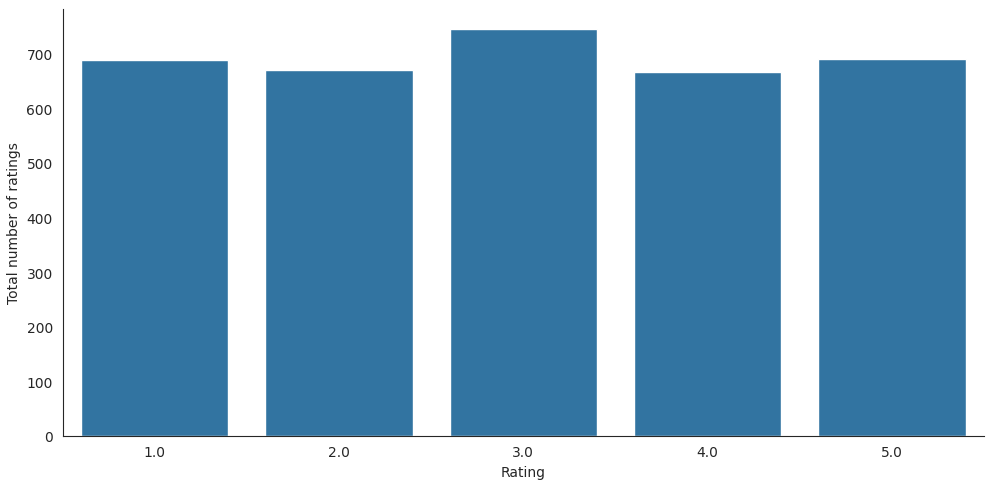

In [14]:
# Set the style for the plot
with sns.axes_style('white'):
    # Create the catplot
    # aspect --->  Sets the aspect ratio
    #  kind ---> Specifies that the plot type is a count plot
    g = sns.catplot(x="Rating", data=data, aspect=2.0, kind='count')

# Set the y-axis label
g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

## Unique Users and products


In [15]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",data.shape[0])
print("Total No of Users   :", len(np.unique(data.UserId)))
print("Total No of products  :", len(np.unique(data.ProductId)))

Total data 
--------------------------------------------------

Total no of ratings : 3461
Total No of Users   : 2492
Total No of products  : 6


## Dropping the TimeStamp Column

In [16]:
# #Dropping the Timestamp column

# data.drop(['time'], axis=1,inplace=True)

# Analyzing the rating

In [17]:
#Analysis of rating given by the user
#no_of_rated_products_per_user --> stores the result of the analysis. It represents the number of rated products per user
#data.groupb --> groups "uerid" & It calculates the number of ratings given by each user.
# sort_values(ascending=False) --> sorts the resulting counts in descending order.
no_of_rated_products_per_user = data.groupby(by='UserId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

UserId
4647    6
508     5
3094    5
1324    4
1967    4
Name: Rating, dtype: int64

In [18]:
no_of_rated_products_per_user.describe()


count    2492.000000
mean        1.388844
std         0.653622
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: Rating, dtype: float64

In [19]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<Axes: title={'center': 'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

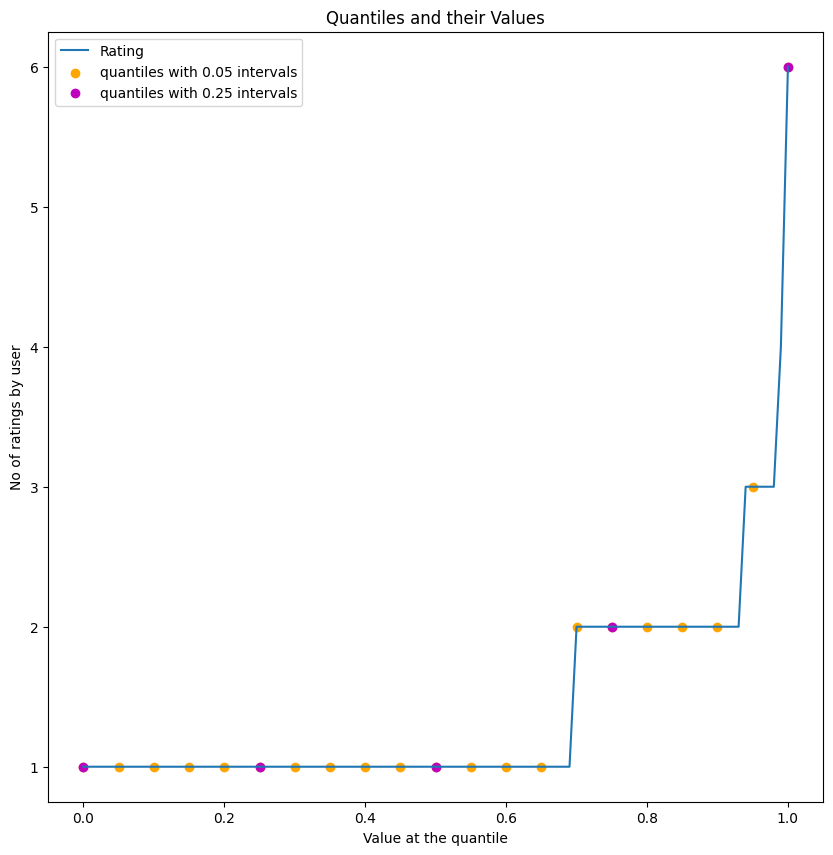

In [20]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [21]:
# number of users who have rated more than 50 products
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 0



# Popularity Based Recommendation



In [22]:
#Getting the new dataframe which contains users who has given 50 or more ratings
# بيجيب المنتج اللي تقيم اكتر من 50 مره
# groupby -->  creates separate groups for each unique product.

new_df=data.groupby("ProductId").filter(lambda x:x['Rating'].count() >=50)

In [23]:
new_df

,UserId,ProductId,Rating
0,3596,2,3.0
1,3389,3,3.0
2,1279,6,5.0
3,3878,6,3.0
4,4614,3,5.0
...,...,...,...
3456,4975,6,4.0
3457,2628,1,2.0
3458,2445,6,3.0
3459,1915,3,1.0


Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-1.0, 0, ''),
 Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, '')]

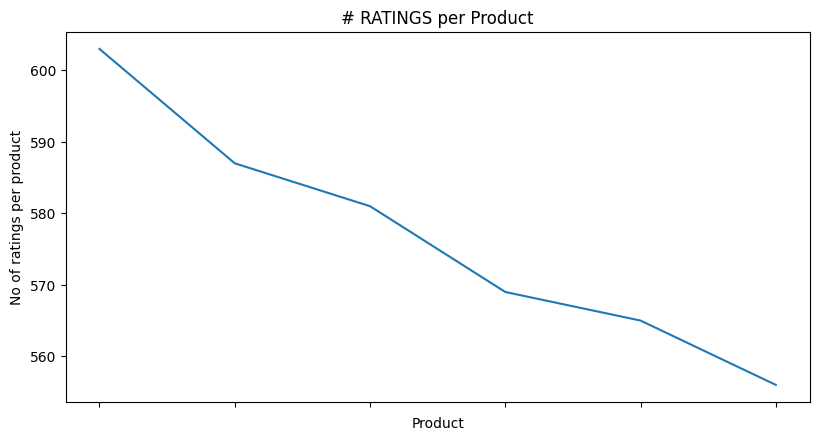

In [24]:
# بيحسب الريت ل كل مشروب وبعدين يرتبهم بترتيب تنازلي
no_of_ratings_per_product = new_df.groupby(by='ProductId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [25]:
#Average rating of the product
#بجيب متوسط التقيم لكل منتج
new_df.groupby('ProductId')['Rating'].mean().head()

ProductId
1    2.870912
2    3.059701
3    2.973022
4    3.051327
5    3.010545
Name: Rating, dtype: float64

In [26]:

new_df.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head()


ProductId
2    3.059701
4    3.051327
6    3.032368
5    3.010545
3    2.973022
Name: Rating, dtype: float64

In [27]:
#Total no of rating for product
#يقوم بحساب العدد الإجمالي للتقييمات لكل منتج
new_df.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head()

ProductId
2    603
6    587
1    581
5    569
4    565
Name: Rating, dtype: int64

In [28]:

# So, `ratings_mean_count` will be a DataFrame where each row represents a product,
# and it will have two columns: 'productId' and 'Rating'.
# The 'Rating' column will contain the mean rating for each product,
# calculated from the ratings in the original DataFrame `new_df`.
# This DataFrame can then be used for further analysis or visualizatio


ratings_mean_count = pd.DataFrame(new_df.groupby('ProductId')['Rating'].mean())


In [29]:
# So, after executing this line of code, the DataFrame
# `ratings_mean_count` will have a new column 'rating_counts' containing the count of ratings for each product.
# Each row in this DataFrame still represents a unique product,
# and it now has two columns: 'Rating' (representing the mean rating for each product)
# and 'rating_counts' (representing the count of ratings for each product).
# This combined information provides a more comprehensive view of the ratings data for each product.


ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('ProductId')['Rating'].count())


In [30]:
ratings_mean_count.head()


,Rating,rating_counts
ProductId,,
1,2.870912,581
2,3.059701,603
3,2.973022,556
4,3.051327,565
5,3.010545,569


In [31]:
ratings_mean_count.shape

(6, 2)

In [32]:
ratings_mean_count['rating_counts'].max()


603

<Figure size 800x600 with 0 Axes>

<Axes: >

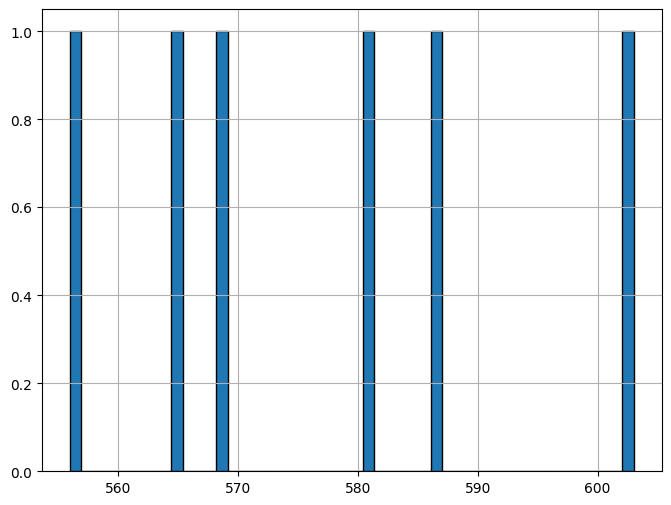

In [33]:
# create a histogram of the count of ratings per product
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Axes: >

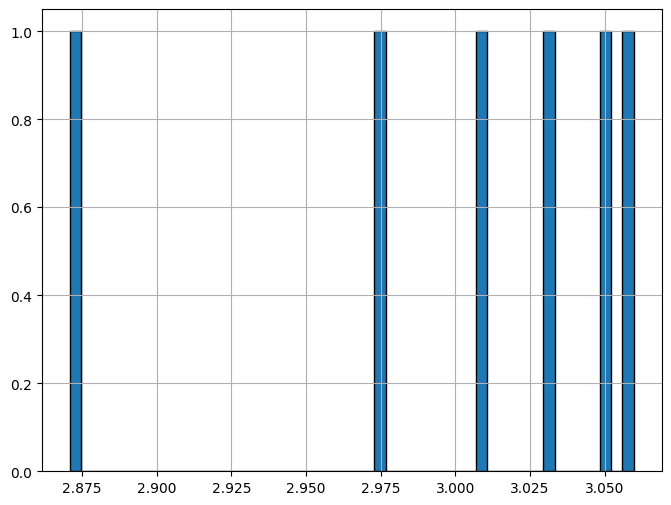

In [34]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

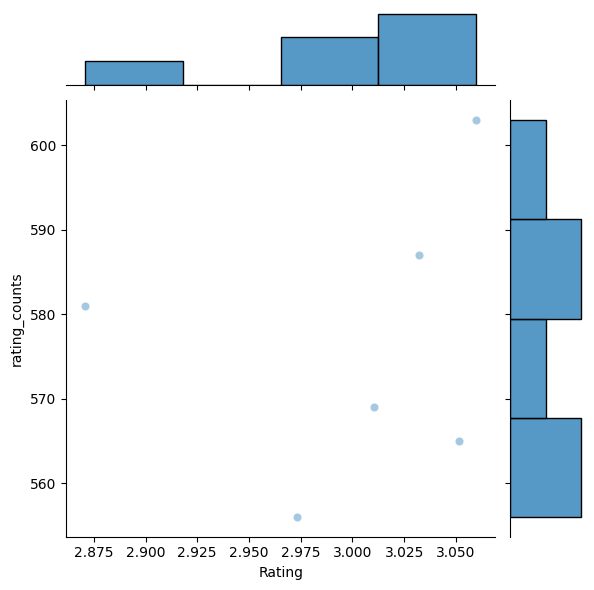

In [35]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<Axes: xlabel='ProductId'>

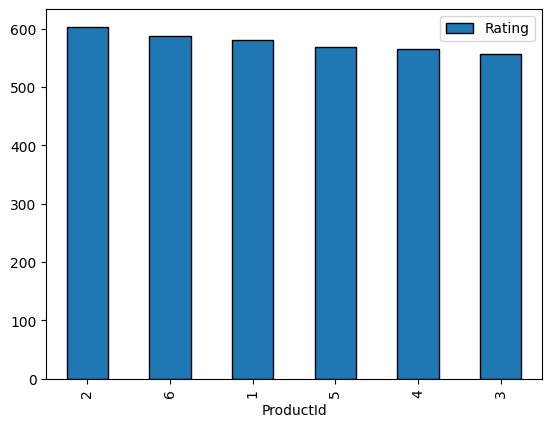

In [36]:
popular_products = pd.DataFrame(new_df.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaberative filtering (Item-Item recommedation)





In [37]:
!pip install scikit-surprise

In [38]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [39]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [40]:
word_to_int_mapping = {word: idx for idx, word in enumerate(set(new_df['ProductId'].unique()))}
new_df['ProductId'] = new_df['ProductId'].map(word_to_int_mapping)

In [41]:
#Reading the dataset
# Reader --> used to parse the file & argument to provide the necessary information about the rating scale.
# rating_scale -->  parameter specifies the minimum and maximum ratings in the dataset
reader = Reader(rating_scale=(1, 5))
# data -->  used to train and evaluate recommendation models.
data = Dataset.load_from_df(new_df,reader)



In [42]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.5,random_state=5)

In [43]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
# This model can then be used to make recommendations based on item similarities.
#  k --> which determines the number of nearest neighbors to consider when making predictions.
#  sim_options -->   dictionary specifying the options for computing similarities between users or items
algo = KNNWithMeans(k=3, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [44]:
# run the trained model against the testset
test_pred = algo.test(testset)


In [45]:
test_pred
# uid: The user ID for which the prediction was made.
# iid: The item ID for which the prediction was made.
# r_ui: The true rating provided by the user.
# est: The estimated rating predicted by the model.
# - For example, in the first prediction, the model estimated a rating of approximately 3.52 for item 1 by user 45,
# while the true rating was 3.0. The model used 3 actual neighbors for this prediction, and it was not considered impossible.

[Prediction(uid=1945, iid=5, r_ui=5.0, est=2.994219653179191, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=1429, iid=5, r_ui=2.0, est=2.994219653179191, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2759, iid=0, r_ui=5.0, est=2.994219653179191, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=4038, iid=2, r_ui=4.0, est=2.5707247029675093, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=1352, iid=5, r_ui=5.0, est=2.994219653179191, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2324, iid=4, r_ui=4.0, est=2.994219653179191, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2400, iid=1, r_ui=1.0, est=2.994219653179191, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=2556, iid=0, r_ui=1.0, est=2.9942196

In [46]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.5088


1.5088078126127744

# Model-based collaborative filtering system


In [47]:

new_df1=new_df.head(500)
ratings_matrix = new_df1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_matrix.head()

ProductId,0,1,2,3,4,5
UserId,,,,,,
12,0.0,0.0,5.0,0.0,0.0,0.0
21,5.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,5.0,2.0
48,0.0,2.0,0.0,0.0,0.0,0.0
59,2.0,0.0,1.0,0.0,0.0,0.0


In [48]:
ratings_matrix.shape

(472, 6)

As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [49]:
ratings_matrix.shape


(472, 6)

Transposing the matrix

In [50]:
X = ratings_matrix.T
X.head()

UserId,12,21,39,48,59,71,76,89,95,96,...,4904,4924,4928,4934,4937,4964,4965,4978,4986,4999
ProductId,,,,,,,,,,,,,,,,,,,,,
0,0.0,5.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
2,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [51]:
X.shape


(6, 472)

Unique products in subset of data


In [52]:
X1 = X


In [53]:
#Decomposing the Matrix( Singular Value Decomposition )
# TruncatedSVD --> dimensionality reduction
#  n --> features
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=3)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(6, 3)

In [54]:
#Correlation Matrix
# corrcoef --> calculates the correlation coefficients between variables in an array-like object.
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(6, 6)

In [55]:
X.index[2]


2

Index # of product ID purchased by customer



In [56]:
i = int("5")

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

5

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [57]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(6,)



```
# This is formatted as code
```

Recommending top 3 highly correlated products in sequence



In [58]:
# Assuming you have a DataFrame or dictionary containing product IDs and their corresponding names
product_names = {
    1: 'Tea',
    2: 'Tea_Milk',
    3: 'Nescaffee black',
    4: 'Nescaffee',
    5: 'Cacao',
    6:'Cacao_Milk'
    
}


# Recommend contains product IDs
recommend_product_ids = list(X.index[correlation_product_ID > 0.30])

# Removes the item already bought by the customer
recommend_product_ids.remove(i)

# Create a list to store recommended product names
recommend_product_names = []

# Iterate over the recommended product IDs
for product_id in recommend_product_ids[:4]:
    # Check if the product ID exists in the product_names dictionary
    if product_id in product_names:
        # If the product ID exists, append the corresponding product name to the list
        recommend_product_names.append(product_names[product_id])
    else:
        # If the product ID doesn't exist, handle it gracefully (e.g., print a message or skip)
        print(f"Product ID {product_id} does not have a corresponding name.")

print(recommend_product_names)


['Tea_Milk', 'Nescaffee black']


RMSE: 0.3317


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs. Predicted Ratings')

Text(0.5, 0, 'Actual Ratings')

Text(0, 0.5, 'Predicted Ratings')

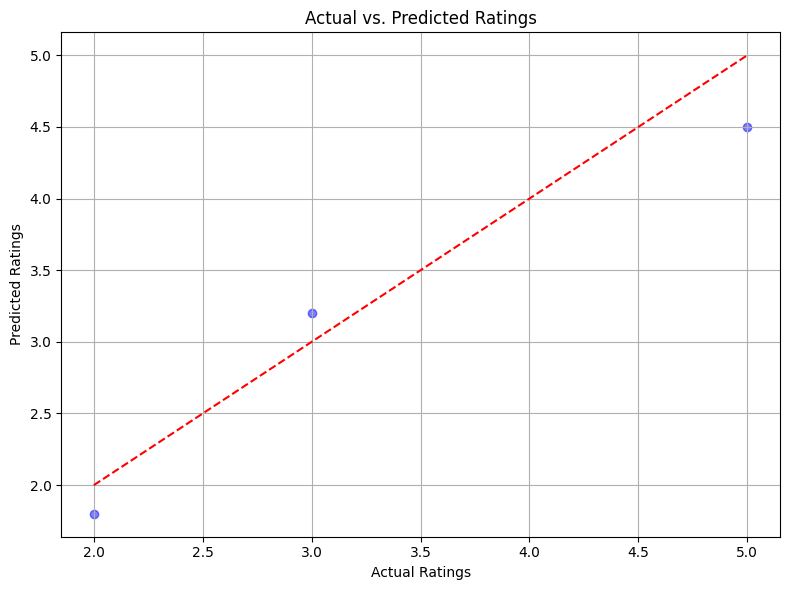

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from surprise import accuracy

# Example data (replace with your actual test_pred)
test_pred = [
    ('uid1', 'iid1', 5.0, 4.5, {'was_impossible': False}),  # Example tuple structure
    ('uid2', 'iid2', 3.0, 3.2, {'was_impossible': False}),
    ('uid3', 'iid3', 2.0, 1.8, {'was_impossible': True}),
    # Add more tuples here as per your actual data structure
]

# Extract actual ratings (r_ui) and predicted ratings (est)
actual_ratings = [pred[2] for pred in test_pred]  # Index 2 corresponds to r_ui
predicted_ratings = [pred[3] for pred in test_pred]  # Index 3 corresponds to est

# Calculate RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(test_pred, verbose=True)

# Plotting actual vs. predicted ratings
plt.figure(figsize=(8, 6))
plt.scatter(actual_ratings, predicted_ratings, color='blue', alpha=0.5)
plt.plot([min(actual_ratings), max(actual_ratings)], [min(actual_ratings), max(actual_ratings)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix for Product Recommendations')

([<matplotlib.axis.XTick at 0x203d088a450>,
 [Text(0, 0, 'Tea'),
  Text(1, 0, 'Tea_Milk'),
  Text(2, 0, 'Nescaffee black'),
  Text(3, 0, 'Nescaffee'),
  Text(4, 0, 'Cacao'),
  Text(5, 0, 'Cacao_Milk')])

([<matplotlib.axis.YTick at 0x203d08a9d10>,
 [Text(0, 0, 'Tea'),
  Text(0, 1, 'Tea_Milk'),
  Text(0, 2, 'Nescaffee black'),
  Text(0, 3, 'Nescaffee'),
  Text(0, 4, 'Cacao'),
  Text(0, 5, 'Cacao_Milk')])

Text(0, 0.5, 'Actual Purchases')

Text(0.5, 0, 'Recommended Products')

Text(0, 0, '1')

Text(1, 0, '0')

Text(2, 0, '0')

Text(3, 0, '0')

Text(4, 0, '0')

Text(5, 0, '0')

Text(0, 1, '0')

Text(1, 1, '0')

Text(2, 1, '0')

Text(3, 1, '0')

Text(4, 1, '1')

Text(5, 1, '0')

Text(0, 2, '0')

Text(1, 2, '1')

Text(2, 2, '0')

Text(3, 2, '0')

Text(4, 2, '0')

Text(5, 2, '0')

Text(0, 3, '0')

Text(1, 3, '0')

Text(2, 3, '0')

Text(3, 3, '0')

Text(4, 3, '0')

Text(5, 3, '0')

Text(0, 4, '0')

Text(1, 4, '0')

Text(2, 4, '0')

Text(3, 4, '1')

Text(4, 4, '0')

Text(5, 4, '0')

Text(0, 5, '0')

Text(1, 5, '0')

Text(2, 5, '0')

Text(3, 5, '0')

Text(4, 5, '0')

Text(5, 5, '0')

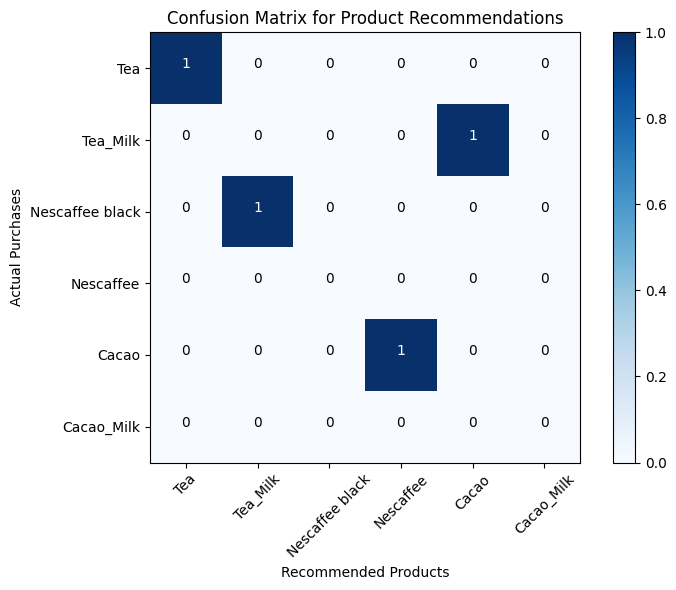

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (simulated for illustration)
actual_purchases = [1, 3, 5, 2]  # Example: products actually purchased by customers
recommended_products = [1, 2, 4, 5]  # Example: products recommended by your model

# Initialize product names
product_names = {
    1: 'Tea',
    2: 'Tea_Milk',
    3: 'Nescaffee black',
    4: 'Nescaffee',
    5: 'Cacao',
    6: 'Cacao_Milk'
}

# Number of products
num_products = len(product_names)

# Initialize confusion matrix
confusion_matrix = np.zeros((num_products, num_products), dtype=int)

# Populate confusion matrix
for actual, recommended in zip(actual_purchases, recommended_products):
    # Increment corresponding cell in confusion matrix
    confusion_matrix[actual - 1, recommended - 1] += 1  # Adjust indices for zero-based indexing

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Product Recommendations')
plt.colorbar()

tick_marks = np.arange(num_products)
plt.xticks(tick_marks, list(product_names.values()), rotation=45)
plt.yticks(tick_marks, list(product_names.values()))

plt.ylabel('Actual Purchases')
plt.xlabel('Recommended Products')

# Displaying the values in the Confusion Matrix
for i in range(num_products):
    for j in range(num_products):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.


In [61]:
pip install fastapi uvicorn scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [62]:
import joblib
joblib.dump(algo, 'algo.joblib')


['algo.joblib']